### HYO HRSTEM images anlaysis 

The following are imports and functions to plot or process some of the data

In [7]:
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from rsciio import digitalmicrograph
import matplotlib.pyplot as plt
from vpcffit.utils import select_files, save_vpcfs, load_vpcfs, xy_to_rt, rt_to_xy, create_zone_axes
from vpcffit.vpcffit import get_vpcf_from_cif, get_vpcf_from_cif2, align_point_clouds 
from vpcffit.vpcffit import supercell_axis_cif, get_image_from_atoms, create_vpcfs_images
from vpcffit.vpcffit import extract_peak_coords
from ase.visualize import view
import os
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact
from ipywidgets import interact, HBox, VBox
from vpcffit.vpcffit import align_point_clouds, near_neighbor_distance, crop_at_position
from scipy.ndimage import rotate
from joblib import Parallel, delayed
import copy
import atomap.api as am
import hyperspy.api as hs
from scipy.optimize import minimize
import h5py
import numpy as np
from tqdm import tqdm
import os


#A function to create an interactive plot to compare two vPCFs
def compare_vpcfs(vpcf1, vpcf2, fix_zone = False, limit = 500, names = ["vpcf1","vpcf2"], colors = ['red', 'blue'], markersize = [6,4]):
    
    vPCF = go.Scatterpolar(theta=[0], r=[0], mode='markers', name='vPCF1',
                            marker = dict(color=colors[0], size=markersize[0]))
    vPCF2 = go.Scatterpolar(theta=[0], r=[0], mode='markers', name='vPCF2',
                                marker = dict(color=colors[1], size=markersize[1]))
    
    fig = go.FigureWidget(data=[vPCF, vPCF2])
    
    # Create a function to update the plot
    def update_plot(phase, phase2):
        if fix_zone:
            vpc1 = vpcf1[phase][(np.sqrt(vpcf1[phase][:,0]**2+vpcf1[phase][:,1]**2)<limit)]
            vpc2 = vpcf2[phase][(np.sqrt(vpcf2[phase][:,0]**2+vpcf2[phase][:,1]**2)<limit)]
            aligned = align_point_clouds(vpc1, vpc2)
            fig.data[0].name = names[0]
            fig.data[1].name = names[1]
        else:
            vpc1 = vpcf1[phase][(np.sqrt(vpcf1[phase][:,0]**2+vpcf1[phase][:,1]**2)<limit)]
            vpc2 = vpcf2[phase2][(np.sqrt(vpcf2[phase2][:,0]**2+vpcf2[phase2][:,1]**2)<limit)]
            aligned = align_point_clouds(vpc1, vpc2)
            fig.data[0].name = phase
            fig.data[1].name = phase2
        rt_data = xy_to_rt(aligned[1]) # align_point_clouds returns the reference vpcf in the second position of the list
        rt_data2 = xy_to_rt(aligned[0]) # align_point_clouds returns the target vpcf after rotation in the first position of the list
        fig.data[0].update(r=rt_data[:, 0], theta=rt_data[:, 1] * 180 / np.pi)
        fig.data[1].update(r=rt_data2[:, 0], theta=rt_data2[:, 1] * 180 / np.pi)
        fig.show()
    # Create a dropdown for selecting the plot type
    plot_dropdown = widgets.Dropdown(
        options=list(vpcf1.keys()),
        description="First vPCF:"
    )

    plot_dropdown_2 = widgets.Dropdown(
        options=list(vpcf2.keys()),
        description="Second vPCF:",
        disabled=fix_zone
    )

    fig.update_layout(
        #title="Select the vPCF to plot",
        width=800,  # Set the width to 800 pixels
        height=600,  # Set the height to 600 pixels
        polar=dict(radialaxis=dict(range=[0, limit],
                  showline=False,  # Show the radial axis lines
                  linewidth=1.5,    # Set the width of the radial axis lines
                  linecolor="black",  # Set the color of the radial axis lines
                  showticklabels=False,
                  ),
                  angularaxis=dict(
                          showline=True,  # Show the radial axis lines
                          linewidth=1.5,    # Set the width of the radial axis lines
                          linecolor="black"  # Set the color of the radial axis lines
                          ),
                  bgcolor="rgba(0,0,0,0)",# Transparent background for polar plot area
                          ),
        legend=dict(orientation="h",
                   xanchor="center",
                   x=0.5,                       
           ),
    )

    [interact(update_plot, phase=plot_dropdown, phase2=plot_dropdown_2)]
    
def compare_exp_plot(match_DB, target, keys, sigma_threshold = 3, save = False, file= None, model = 'Powell', mark_size=5):
    tree_values= match_DB[0]
    rotation = match_DB[1]
    bs = match_DB[2]
    sigma = match_DB[3]
    best_match_itree = np.argmin(tree_values)
    best_scale_match = bs[best_match_itree]
    best_rotation =  rotation[best_match_itree]
    best_match_pc = np.array(library_pcs[best_match_itree]) 
    
    sorted_tree_values, sorted_keys, sorted_sigma, sorted_bs, sorted_rotation = zip(*sorted(zip(tree_values, keys, sigma, bs, rotation)))
    
    #compare the arrays to see differences
    differences = np.abs(np.array(sorted_tree_values) - sorted_tree_values[0])
    combined_sigma = np.sqrt((sigma_threshold*np.array(sigma))**2 + (sigma_threshold*np.array(sorted_sigma[0]))**2)
    within_sigma = differences <= combined_sigma
    matches = np.where(within_sigma)[0]
    colorbar = ['#1f77b4'] * len(keys)
    best_match_tree = []
    for index in matches:
        colorbar[index] = 'pink'
        best_match_tree.append(sorted_keys[index])

    #plot
    bar1 = go.Bar(
        x=sorted_keys,
        y=sorted_tree_values,
        marker_color = colorbar,
        text=[f"{num:.2f}   " for num in sorted_bs],         # Text on top of each bar
        textposition='outside',  # Position text above bars
        textangle=90,
        error_y = dict(
            type='data',           # Type of error, can also be 'percent' or 'constant'
            array=sigma,    # Error values for each bar
            #visible=True           # Display the error bars
        ),
        hovertemplate=(
                    '<b>Category:</b> %{x}<br>'  # Displays the x value (Category)
                    '<b>Value:</b> %{y}<br>'     # Displays the y value
                    '<b>scale:</b> %{text}'  # Displays the error value
                    '<extra></extra>'  # Removes the default trace name
                )
        )
    
    # vPCF initially showing Experimental data
    vPCF1 = go.Scatterpolar(theta=np.mod(xy_to_rt(target)[:,1] + best_rotation,2*np.pi)*180/np.pi,
                            r=xy_to_rt(target)[:,0]*best_scale_match,
                            mode='markers', 
                            name='Experimental<br>vPCFs',
                            marker=dict(color='blue', size=mark_size))
    
    # vPCF initially showing best match
    vPCF2 = go.Scatterpolar(theta=xy_to_rt(best_match_pc)[:,1]*180/np.pi,
                            r=xy_to_rt(best_match_pc)[:,0],
                            mode='markers',
                            name="Best Matches<br>" + str(best_match_tree),
                            marker = dict(color='red', size=mark_size-int(mark_size/2)))
    
    fig = go.FigureWidget(data=[bar1])
    #fig1 = go.FigureWidget(data=[virtual])
    #fig2 = go.FigureWidget(data=[experiment])
    fig3 = go.FigureWidget(data=[vPCF1, vPCF2])

    
    # Customize layout
    fig.update_layout(
        height=400, width=800,
        showlegend=False,
        title = "Average Near Neighbor Distance",
        xaxis=dict(tickangle=90),  # Rotate x-axis labels
        xaxis2=dict(tickangle=90),
        hovermode="closest",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="left",
            x=0
        )
    )
   
    fig3.update_layout(height=400, width=400,
                       legend=dict(
                                    orientation="h",
                                    yanchor="bottom",
                                    y=1.02,
                                    xanchor="left",
                                    x=0
                                    ),
                        polar=dict(radialaxis=dict(range=[0, limit],
                              showline=False,  # Show the radial axis lines
                              linewidth=1.5,    # Set the width of the radial axis lines
                              linecolor="black",  # Set the color of the radial axis lines
                              showticklabels=False,
                              showgrid=True,  # Turn on the radial grid
                              gridcolor="grey",  # Color of the radial grid
                              griddash="dot",  # Style of the radial grid (solid, dot, dash)
                              gridwidth=1  # Thickness of the grid line
                              ),
                              angularaxis=dict(
                                      showline=True,  # Show the radial axis lines
                                      linewidth=1.5,    # Set the width of the radial axis lines
                                      linecolor="black"  # Set the color of the radial axis lines
                                      ),
                              bgcolor="rgba(0,0,0,0)",# Transparent background for polar plot area
                                      ),
    )
    
    def onclick_fn(trace, points, state):
        inds = np.array(points.point_inds)
        if inds.size:
            vPCFs2.name = str(points.xs)
            index = keys.index(vPCFs2.name[2:-2])
            vPCFs1.r = xy_to_rt(target)[:,0]*bs[index]
            vPCFs1.theta = np.mod(xy_to_rt(target)[:,1]+rotation[index],2*np.pi)*180/np.pi
            vPCFs2.r = xy_to_rt(library_pcs[index])[:,0]
            vPCFs2.theta = xy_to_rt(library_pcs[index])[:,1]*180/np.pi
            rotated_image, virtual, virtual_size, coord_DB = images_com (rotation[index], index)
            vir.z = - virtual
            exp.z = - rotated_image
            for i, key in enumerate(coord_DB):
                fig1.data[i+1].x = coord_DB[key][:,1]
                fig1.data[i+1].y = coord_DB[key][:,0]
    
    bar1 = fig.data[0]
    #vir = fig1.data[0]
    #exp = fig2.data[0]
    vPCFs1 = fig3.data[0]
    vPCFs2 = fig3.data[1]
    bar1.on_click(onclick_fn)
    
    # ipywidgets
    from ipywidgets import HBox, VBox, Button
    if save:
        fig.write_html(file+"_bar_plot.html")
        fig3.write_html(file+"_vPCFs.html")
        #fig1.write_html(file+"_MODEL.html")
        #fig2.write_html(file+"_EXP.html")
    display(HBox([fig,fig3]))
    return vPCFs1, vPCFs2


def compare_exp_library_plot(match_DB, target, keys, virtual_dic, atomic_models,exp_img, pixel_size, sigma_threshold = 3, save = False, file= None, model = 'Powell', mark_size=5):
    tree_values= match_DB[0]
    rotation = match_DB[1]
    bs = match_DB[2]
    sigma = match_DB[3]
    best_match_itree = np.argmin(tree_values)
    best_scale_match = bs[best_match_itree]
    best_rotation =  rotation[best_match_itree]
    best_match_pc = np.array(library_pcs[best_match_itree]) 
    
    sorted_tree_values, sorted_keys, sorted_sigma, sorted_bs, sorted_rotation = zip(*sorted(zip(tree_values, keys, sigma, bs, rotation)))
    
    #compare the arrays to see differences
    differences = np.abs(np.array(sorted_tree_values) - sorted_tree_values[0])
    combined_sigma = np.sqrt((sigma_threshold*np.array(sigma))**2 + (sigma_threshold*np.array(sorted_sigma[0]))**2)
    within_sigma = differences <= combined_sigma
    matches = np.where(within_sigma)[0]
    colorbar = ['#1f77b4'] * len(keys)
    best_match_tree = []
    for index in matches:
        colorbar[index] = 'pink'
        best_match_tree.append(sorted_keys[index])
    
    size_exp=min(exp_img.shape)
    exp_img=exp_img[0:size_exp,0:size_exp]
    # select and crop STEM images
    def images_com (rot, index):
        rotated_image = rotate(exp_img,-rot*180/np.pi, reshape=False)
        crop_size = int(min(exp_img.shape[0], exp_img.shape[1]) / np.sqrt(2))
        virtual_pixel = virtual_dic[keys[index]][1]
        virtual_size = int(crop_size*pixel_size/virtual_pixel)
        virtual = virtual_dic[keys[index]][0]
        size_virtual=min(virtual.shape)
        virtual=virtual[0:size_virtual,0:size_virtual]
        
        if virtual.shape[0] < virtual_size:
            crop_2 = int(virtual.shape[0]*virtual_pixel/pixel_size)
            rotated_image = crop_at_position(rotated_image,crop_2, crop_2, rotated_image.shape[0]//2,rotated_image.shape[1]//2)
        else:
            rotated_image = crop_at_position(rotated_image,crop_size, crop_size, rotated_image.shape[0]//2,rotated_image.shape[1]//2)
            virtual = crop_at_position(virtual,virtual_size, virtual_size, virtual.shape[0]//2,virtual.shape[1]//2)    
        model_over = atomic_models[keys[index]]
        unique_species = sorted(set(model_over.get_chemical_symbols()))
        coord_DB = {}
        for atom in unique_species:
                coord_DB[atom] = np.array([model_over.positions[i]
                                           for i, condition in enumerate(model_over.get_chemical_symbols())
                                           if condition==atom])[:,0:2]
                coord_DB[atom] = coord_DB[atom][(coord_DB[atom][:,1]/virtual_pixel) < virtual_size//3] / virtual_pixel
                coord_DB[atom] = coord_DB[atom][coord_DB[atom][:,0] < virtual_size//3]
        
        img = hs.signals.Signal2D(virtual)
        image_fit = am.get_atom_positions(img, pca=False, separation=7)
        sublattices = am.Sublattice(image_fit, image=img.data, fix_negative_values=True)
        points = sublattices.atom_positions[:, [1, 0]]
        
        def objective(translation, points1, points2):
            dx, dy = translation  # Translation in x and y
            translated_points1 = points1 + np.array([dx, dy])
            distances = np.linalg.norm(translated_points1[:, None] - points2, axis=2)
            return np.sum(np.min(distances, axis=1))  # Sum of distances to nearest neighbors
        # Minimize the objective function
        result = minimize(objective, np.array([0, 0]), args=(points, coord_DB['Hf']), method=model)
        for key in coord_DB:
            coord_DB[key] -= result.x
        return rotated_image, virtual,virtual_size, coord_DB
    
    rotated_image, virtual, virtual_size,coord_DB = images_com (best_rotation, best_match_itree)
    #plot
    bar1 = go.Bar(
        x=sorted_keys,
        y=sorted_tree_values,
        marker_color = colorbar,
        text=[f"{num:.2f}   " for num in sorted_bs],         # Text on top of each bar
        textposition='outside',  # Position text above bars
        textangle=90,
        error_y = dict(
            type='data',           # Type of error, can also be 'percent' or 'constant'
            array=sigma,    # Error values for each bar
            #visible=True           # Display the error bars
        ),
        hovertemplate=(
                    '<b>Category:</b> %{x}<br>'  # Displays the x value (Category)
                    '<b>Value:</b> %{y}<br>'     # Displays the y value
                    '<b>scale:</b> %{text}'  # Displays the error value
                    '<extra></extra>'  # Removes the default trace name
                )
        )
    #Plot the Virtual image from the dictionary provided initially showing best match
    virtual = go.Heatmap(
    z=-virtual,
    colorscale="Greys",
    showscale=False
    )
    #Plot all sublattices from the model initially showing best match
    fig4 = go.FigureWidget()
    # Loop through the data to add scatter plots for each group
    for key in coord_DB:
        fig4.add_trace(go.Scatter(
            x=coord_DB[key][:,1],
            y=coord_DB[key][:,0],
            mode='markers',  # Use 'markers+lines' for both
            name=key,  # Legend entry
            marker=dict(
            size=5  # Set marker size
            )
        ))
    #Plot experimental STEM image
    experiment = go.Heatmap(
    z=-rotated_image,
    colorscale="Greys",
    showscale=False
    )
    
    # vPCF initially showing Experimental data
    vPCF1 = go.Scatterpolar(theta=np.mod(xy_to_rt(target)[:,1] + best_rotation,2*np.pi)*180/np.pi,
                            r=xy_to_rt(target)[:,0]*best_scale_match,
                            mode='markers', 
                            name='Experimental<br>vPCFs',
                            marker=dict(color='blue', size=mark_size))
    
    # vPCF initially showing best match
    vPCF2 = go.Scatterpolar(theta=xy_to_rt(best_match_pc)[:,1]*180/np.pi,
                            r=xy_to_rt(best_match_pc)[:,0],
                            mode='markers',
                            name="Best Matches<br>" + str(best_match_tree),
                            marker = dict(color='red', size=mark_size-int(mark_size/2)))
    
    fig = go.FigureWidget(data=[bar1])
    fig1 = go.FigureWidget(data=[virtual])
    fig2 = go.FigureWidget(data=[experiment])
    fig3 = go.FigureWidget(data=[vPCF1, vPCF2])
    for trace in fig4.data:
        fig1.add_trace(trace)
    
    # Customize layout
    fig.update_layout(
        height=400, width=800,
        showlegend=False,
        title = "Average Near Neighbor Distance",
        xaxis=dict(tickangle=90),  # Rotate x-axis labels
        xaxis2=dict(tickangle=90),
        hovermode="closest",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="left",
            x=0
        )
    )
    fig1.update_layout(
        height=400, width=400,
        title = "Simulated Image",
        xaxis=dict(
        #range=[0, virtual_size],
        tickvals=[],  # No ticks
        ticktext=[]   # No tick labels
        ),
        yaxis=dict(
        #range=[0, virtual_size],
        tickvals=[],
        ticktext=[]
        ),
        legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0
        )
    )
    fig2.update_layout(
        height=400, width=400,
        title = "Experimental image",
        xaxis=dict(
        tickvals=[],  # No ticks
        ticktext=[]   # No tick labels
    ),
    yaxis=dict(
        tickvals=[],
        ticktext=[]
    )
    )
    
    fig3.update_layout(height=400, width=400,
                       legend=dict(
                                    orientation="h",
                                    yanchor="bottom",
                                    y=1.02,
                                    xanchor="left",
                                    x=0
                                    ),
                        polar=dict(radialaxis=dict(range=[0, limit],
                              showline=False,  # Show the radial axis lines
                              linewidth=1.5,    # Set the width of the radial axis lines
                              linecolor="black",  # Set the color of the radial axis lines
                              showticklabels=False,
                              showgrid=True,  # Turn on the radial grid
                              gridcolor="grey",  # Color of the radial grid
                              griddash="dot",  # Style of the radial grid (solid, dot, dash)
                              gridwidth=1  # Thickness of the grid line
                              ),
                              angularaxis=dict(
                                      showline=True,  # Show the radial axis lines
                                      linewidth=1.5,    # Set the width of the radial axis lines
                                      linecolor="black"  # Set the color of the radial axis lines
                                      ),
                              bgcolor="rgba(0,0,0,0)",# Transparent background for polar plot area
                                      ),
    )
    
    def onclick_fn(trace, points, state):
        inds = np.array(points.point_inds)
        if inds.size:
            vPCFs2.name = str(points.xs)
            index = keys.index(vPCFs2.name[2:-2])
            vPCFs1.r = xy_to_rt(target)[:,0]*bs[index]
            vPCFs1.theta = np.mod(xy_to_rt(target)[:,1]+rotation[index],2*np.pi)*180/np.pi
            vPCFs2.r = xy_to_rt(library_pcs[index])[:,0]
            vPCFs2.theta = xy_to_rt(library_pcs[index])[:,1]*180/np.pi
            rotated_image, virtual, virtual_size, coord_DB = images_com (rotation[index], index)
            vir.z = - virtual
            exp.z = - rotated_image
            for i, key in enumerate(coord_DB):
                fig1.data[i+1].x = coord_DB[key][:,1]
                fig1.data[i+1].y = coord_DB[key][:,0]
    
    bar1 = fig.data[0]
    vir = fig1.data[0]
    exp = fig2.data[0]
    vPCFs1 = fig3.data[0]
    vPCFs2 = fig3.data[1]
    bar1.on_click(onclick_fn)
    
    # ipywidgets
    from ipywidgets import HBox, VBox, Button
    if save:
        fig.write_html(file+"_bar_plot.html")
        fig3.write_html(file+"_vPCFs.html")
        fig1.write_html(file+"_MODEL.html")
        fig2.write_html(file+"_EXP.html")
    display(HBox([VBox([HBox([fig1, fig2]),fig]),fig3]))
    
def split_at_x_underscore(s, x = 2):
    # Split the string at underscores, with a maximum of 2 splits
    parts = s.split('_', x)

    # Check if there are at least three parts after splitting
    if len(parts) > x:
        first_part = '_'.join(parts[:x])
        second_part = parts[x]
        return first_part, second_part
    else:
        return s, ''

# The two functions in this code block are used to add noise to an image: the first add poisson noise, and the second adds scan-line jitter

def add_poisson_noise(img: np.ndarray, px_size: float=0.01, dose: float=1e6) -> np.ndarray:
    valmin, valmax = np.min(img), np.max(img)
    normed = (img - valmin) / (valmax - valmin)
    e_per_px = dose * px_size**2
    return np.random.poisson(normed * e_per_px)


def add_scan_noise(img: np.ndarray, shift_mag: int=4) -> np.ndarray:
    working = img.copy()
    for rownum in range(working.shape[0]):
        rowshift = np.random.randint(-shift_mag, shift_mag+1)
        working[rownum] = np.roll(img[rownum], rowshift)
    return working
    
def parallel_processing(bounds, target, pc, r_limit, nnd='ANND', mask_size=10, **kwargs):

    # Single worker function
    def process_scale(sc):
        scale = sc * 0.001
        ANN = near_neighbor_distance(
            target, pc,
            nnd=nnd,
            r_limit=r_limit,
            scale=scale,
            mask_size=mask_size,
            **kwargs
        )
        # Return the full ANN output + scale (avoid recomputing later)
        return ANN, scale

    # Create range of scales
    scale_values = range(bounds[0], bounds[1] + bounds[2], bounds[2])

    # Run in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_scale)(sc) for sc in scale_values
    )

    return results
    
def parallel_process_pc(pc, target, bounds, r_limit, nnd='ANND', mask_size=10, **kwargs):

    results = parallel_processing(bounds, target, pc, r_limit, nnd, mask_size, **kwargs)

    # Extract tree values to find minimum
    tree_values = [ANN[1] for ANN, scale in results]

    best_idx = np.argmin(tree_values)
    best_ANN, best_scale = results[best_idx]

    aligned_pc, compared_pc, rotation_value = best_ANN[0]
    tree_value = best_ANN[1]
    sigma_value = best_ANN[2]

    return rotation_value, tree_value, best_scale, sigma_value, aligned_pc, compared_pc
# def parallel_processing(bounds, target, pc, r_limit, nnd = 'ANND', mask_size = 10, **kwargs):
#     bf_tree = []
#     bf_scale = []

#     # Function to process items in parallel
#     def process_item(sc):
#         return (near_neighbor_distance(target, pc, 
#                                        nnd=nnd, 
#                                        r_limit = r_limit,
#                                        scale = sc/1000,
#                                        mask_size = mask_size, **kwargs)[1],sc / 1000)

#     # Parallel processing with joblib
#     results = Parallel(n_jobs=-1)(delayed(process_item)(sc) for sc in range(bounds[0], bounds[1] + bounds[2], bounds[2]))

#     # Split results into bf_tree and bf_scale
#     for result, scale in results:
#         bf_tree.append(result)
#         bf_scale.append(scale)

#     return bf_tree, bf_scale

# # Function to handle each item in list_of_pcs
# def parallel_process_pc(pc, target, bounds, r_limit, nnd = 'ANND', mask_size = 10, **kwargs):
#     # Perform parallel processing on bf_tree and bf_scale
#     bf_tree, bf_scale = parallel_processing(bounds, target, pc, r_limit, nnd)

#     # Find best scale and compute ANN
#     best_tree = np.argmin(bf_tree)
#     best_scale = bf_scale[best_tree]


#     # Calculate the rotation and align the two point clouds
#     ANN = near_neighbor_distance(target, pc,
#                                  nnd=nnd,
#                                  r_limit = r_limit,
#                                  scale = best_scale,
#                                  mask_size = 10,
#                                  **kwargs
#                                  )

#     aligned_pc, compared_pc, rotation_value = ANN[0]
#     tree_value = ANN[1]
#     sigma_value = ANN[2]

#     return rotation_value, tree_value, best_scale, sigma_value, aligned_pc, compared_pc

def apply_fourier_transform(array, hanning =True):
    # Get the dimensions of the input array
    a, b, c = array.shape
    
    if hanning:
        window_row = np.hanning(c)[:, np.newaxis]  # Hanning window for rows, reshape to column vector
        window_col = np.hanning(b)  # Hanning window for columns
        hanning_window_2d = window_row * window_col
        
        # Perform Fourier transform on dimensions b and c
        transformed = np.fft.fft2(array*hanning_window_2d, axes=(1, 2))
    else:
        transformed = np.fft.fft2(array, axes=(1, 2))

    # Calculate the magnitude of the transformed values
    magnitude = np.abs(transformed)

    # Rearrange the quadrants to shift the zero frequency component to the center
    shifted = np.fft.fftshift(magnitude, axes=(1, 2))

    # Map the shifted values back to the original array
    mapped_array = np.zeros_like(array, dtype=np.float64)
    
    mapped_array[:, :b, :c] = shifted

    return mapped_array
    

def init_vpcf_h5(filename, image_shape=(1000, 1000)):
    """
    Initialize an HDF5 file for storing vPCF data.
    Each frame stores:
      - atomic_position: (2,) coordinate
      - vpcf_origin: (2,) coordinate
      - vpcf_peaks: variable-length (N_peaks, 2)
      - vpcf_image: fixed (H, W)
    """
    with h5py.File(filename, 'w') as f:
        grp = f.create_group("experiments")
        vlen_float = h5py.vlen_dtype(np.float16)

        # Fixed-shape datasets
        grp.create_dataset(
            "atomic_positions", shape=(0, 2),
            maxshape=(None, 2), dtype=np.float16
        )
        grp.create_dataset(
            "vpcf_origin", shape=(0, 2),
            maxshape=(None, 2), dtype=np.float16
        )
        grp.create_dataset(
            "vpcf_images", shape=(0, *image_shape),
            maxshape=(None, *image_shape), dtype=np.float16
        )

        # Variable-length peaks (different number of peaks per frame)
        grp.create_dataset(
            "vpcf_peaks", shape=(0,), maxshape=(None,), dtype=vlen_float
        )
        grp.create_dataset(
            "peaks_shapes", shape=(0, 2), maxshape=(None, 2), dtype=np.int16
        )

def append_vpcf_frame(filename, atomic_position, vpcf_origin, vpcf_peaks, vpcf_image):
    """
    Append one vPCF frame (atomic_position, origin, peaks, image) to the HDF5 file.
    """
    with h5py.File(filename, 'a') as f:
        grp = f["experiments"]
        idx = len(grp["atomic_positions"])

        # Resize for the new frame
        grp["atomic_positions"].resize((idx + 1, 2))
        grp["vpcf_origin"].resize((idx + 1, 2))
        grp["vpcf_images"].resize((idx + 1, *grp["vpcf_images"].shape[1:]))
        grp["vpcf_peaks"].resize((idx + 1,))
        grp["peaks_shapes"].resize((idx + 1, 2))

        # Write data
        grp["atomic_positions"][idx] = np.array(atomic_position, dtype=np.float16)
        grp["vpcf_origin"][idx] = np.array(vpcf_origin, dtype=np.float16)
        grp["vpcf_images"][idx] = vpcf_image.astype(np.float16)
        grp["vpcf_peaks"][idx] = vpcf_peaks.flatten().astype(np.float16)
        grp["peaks_shapes"][idx] = np.array(vpcf_peaks.shape, dtype=np.int16)

def read_vpcf_frame(filename, frame_index):
    """
    Read one frame (atomic_position, origin, peaks, image) from the HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        grp = f["experiments"]

        atomic_position = grp["atomic_positions"][frame_index]
        vpcf_origin = grp["vpcf_origin"][frame_index]

        flat_peaks = grp["vpcf_peaks"][frame_index]
        peaks_shape = grp["peaks_shapes"][frame_index]
        vpcf_peaks = flat_peaks.reshape(peaks_shape)

        vpcf_image = grp["vpcf_images"][frame_index]

    return atomic_position, vpcf_origin, vpcf_peaks, vpcf_image


def initialize_match_results(filename, library_keys):
    """Initialize the HDF5 file and store library keys once."""
    with h5py.File(filename, "w") as f:
        grp_lib = f.create_group("library")
        f.create_group("columns")
        # Store the library keys once
        dt = h5py.string_dtype(encoding="utf-8")
        grp_lib.create_dataset("keys", data=np.array(library_keys, dtype=dt))

def append_match_results(h5_filename, atomic_position, tree_values, rotation, bs, sigma, library_keys, index):
    """
    Append results for one vPCF frame to the HDF5 file.
    """
    with h5py.File(h5_filename, "a") as f:
        group_name = f"columns/atomicposition_{index:06d}"
        grp = f.create_group(group_name)

        # Save atomic position (x, y)
        grp.create_dataset("atomic_position", data=np.array(atomic_position, dtype=np.float32))

        # Save lists of results
        grp.create_dataset("tree_values", data=np.array(tree_values, dtype=np.float32))
        grp.create_dataset("rotation", data=np.array(rotation, dtype=np.float32))
        grp.create_dataset("bs", data=np.array(bs, dtype=np.float32))
        grp.create_dataset("sigma", data=np.array(sigma, dtype=np.float32))

def read_match_results(filename):
    data = {}
    with h5py.File(filename, "r") as f:
        library_keys = [k.decode("utf-8") for k in f["library/keys"][:]]
        for name in f["columns"].keys():
            grp = f["columns"][name]
            data[name] = {
                "atomic_position": grp["atomic_position"][:],
                "tree_values": grp["tree_values"][:],
                "rotation": grp["rotation"][:],
                "bs": grp["bs"][:],
                "sigma": grp["sigma"][:]
            }
    return library_keys, data


ModuleNotFoundError: No module named 'vpcffit'

# Identify the vPCFs in the membranes

Let's load an image. You can load the imgaes using any of the library available in python, just make sure the pixel size is in Å. 

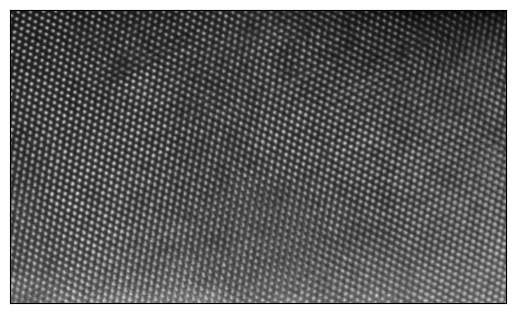

In [13]:
import SingleOrigin as so

#img_path = str(Path.cwd()/"img/Exp_HZO_R3_HAADF.dm3")

# Uncomment and run this line instead of the above if you want to load your own image:
img_path = select_files()[0]

image = so.load_image(
    path = img_path, 
    display_image = True,
    return_path = True,
    images_from_stack = 'all'
)

#Make sure that the pixel size is in Angstroms  
pixel_size = image[1]['pixelSize'][0]*10
image=image[0].astype(np.float16)#[0:292,0:292]

#image = add_poisson_noise(image, px_size=0.01, dose=1e4)
#image = add_scan_noise(image, shift_mag=4)

Center of mass:   0%|          | 0/3462 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/3462 [00:00<?, ?it/s]

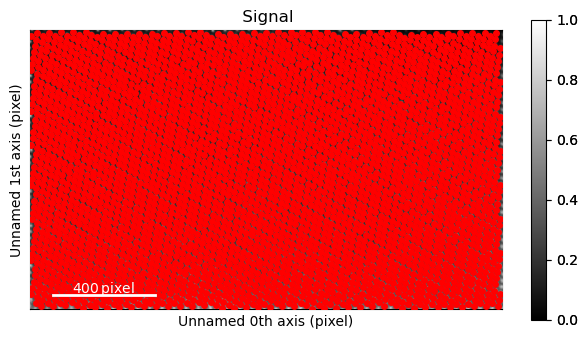

In [37]:
img = hs.signals.Signal2D(image)
image_fit = am.get_atom_positions(img, pca=True, separation=5)
sublattices = am.Sublattice(image_fit, image=img.data)
sublattices.find_nearest_neighbors()
sublattices.refine_atom_positions_using_center_of_mass(show_progressbar=True)
sublattices.refine_atom_positions_using_2d_gaussian(show_progressbar=True)
coords = sublattices.atom_positions * pixel_size


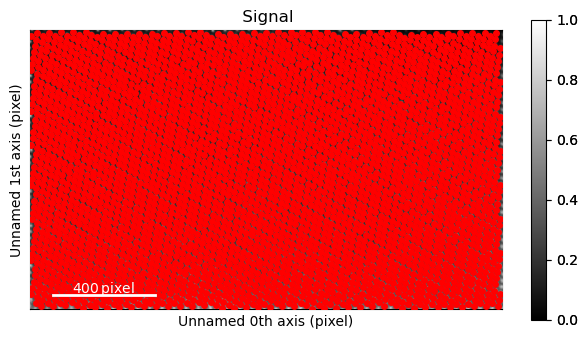

In [41]:
sublattices.plot()

In [ ]:
import atomai as aoi
window_size = 128 #min 64 to get 6 atomic columns in image
step_size = int(window_size/2)

coordinates = aoi.utils.get_coord_grid(image, step_size)
coords = coordinates[0]
imstack_grid_nio, com_grid_nio, frames_grid_nio = aoi.utils.extract_subimages(image, coordinates, window_size)
imstack_grid_nio = np.squeeze(imstack_grid_nio, axis = 3)


In [53]:
imstack_grid_nio_fft = apply_fourier_transform(imstack_grid_nio, hanning = True)
imstack_grid_nio_fft.shape



(448, 128, 128)

In [60]:
imstack_analysis = imstack_grid_nio_fft

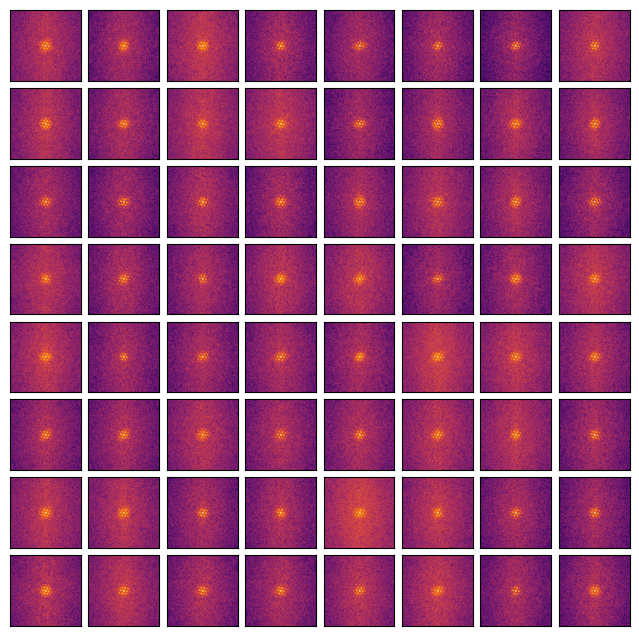

In [61]:
np.random.seed(0)   # fix seed so that we get the same samples displayed at every run

fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack_analysis))
    ax.imshow(np.log(imstack_analysis[i,...]), cmap='inferno')

In [62]:
X_nio = imstack_analysis[...].reshape([-1, window_size*window_size])

In [63]:
from sklearn.cluster import KMeans
nc=4
clusters = KMeans(n_clusters=nc, random_state=0).fit(X_nio)
nio_centers = clusters.cluster_centers_
nio_labels = clusters.labels_

C:\Users\scaldero\anaconda3\envs\TEM_v2\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


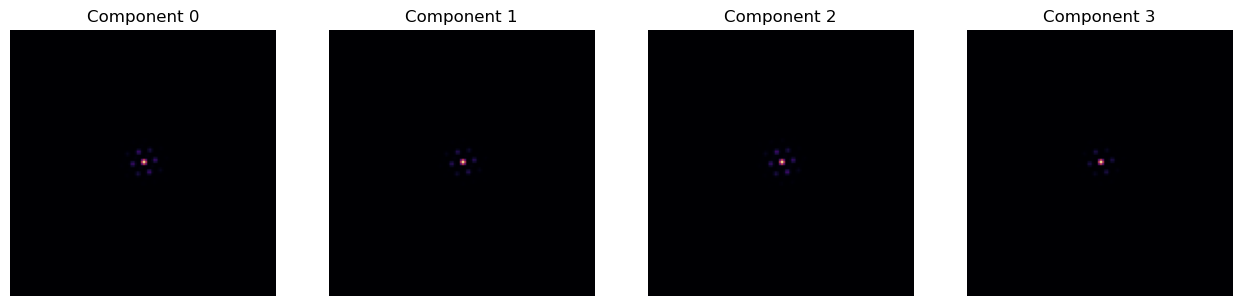

In [64]:
import matplotlib.gridspec as gridspec
rows, cols = 3, 6
gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(nio_centers[i,:].reshape(window_size, window_size)**(1), cmap = 'inferno', origin = 'lower')
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

(-0.5, 27.5, 15.5, -0.5)

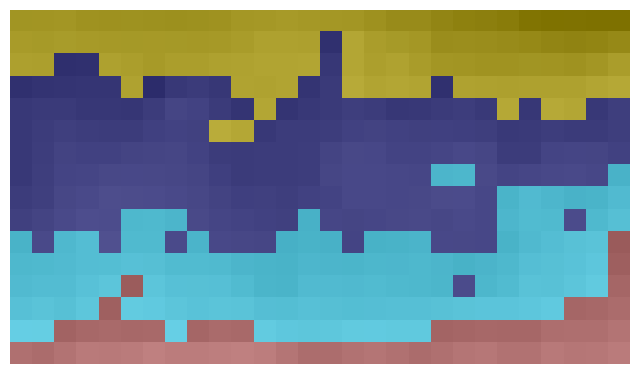

In [65]:
from skimage.transform import resize
plt.figure(figsize=(8,8))
plt.imshow(resize(image, (int(image.shape[0]/step_size)-1,int(image.shape[1]/step_size)))-1, cmap='gray')
z_img = nio_labels.reshape(int(image.shape[0]/step_size)-1,int(image.shape[1]/step_size)-1)
plt.imshow(z_img,  cmap = 'jet', alpha=0.5)
#plt.colorbar()
#plt.gca().invert_yaxis()
plt.axis('off')

# Locate the atomic columns and generate the vPCF for the entire image

In this section, the linearKDE_2D_float16 is used to modify in the script the so_utils.linearKDE_2D function from a single origin to reduce the size of the data using float32. If your image is not very large, that function can be removed. 

In [66]:
### Use this code if the float64 is creating memory issues in SingleOrigin
import SingleOrigin.utils as so_utils
import numpy as np

# orig_linearKDE_2D = so_utils.linearKDE_2D

# def linearKDE_2D_float16(*args, **kwargs):
#     out = orig_linearKDE_2D(*args, **kwargs)
#     if isinstance(out, tuple):
#         return tuple(o.astype(np.float16) if isinstance(o, np.ndarray) else o for o in out)
#     elif isinstance(out, np.ndarray):
#         return out.astype(np.float16)
#     else:
#         return out

# so_utils.linearKDE_2D = linearKDE_2D_float16


######################################
exp_vPCF = create_vpcfs_images((image,pixel_size), fit_atom_gaussian=True, method = 'gauss', blur_vpcf=2, separation=5, show_progressbar=True)

Center of mass:   0%|          | 0/3462 [00:00<?, ?it/s]

Gaussian fitting:   0%|          | 0/3462 [00:00<?, ?it/s]

Make sure you visualize the atomic column fitting by extracting the atomap lattice and plot the vPCF to make sure the peaks are correctly identify. You can modify the parameter (e.g. separation) to improve the fitting. Note that a few false positive or false negative atomic columns do not significantly affect the final result. Save the cartesian vPCF in a different variable.

Text(0.5, 1.0, 'vPCF')

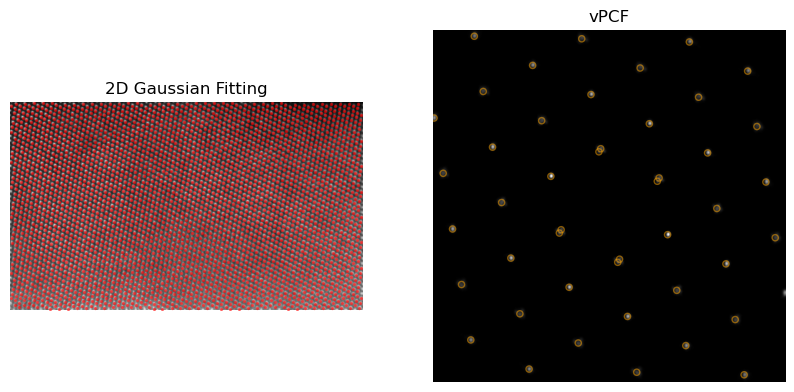

In [67]:
from matplotlib.gridspec import GridSpec

exp_vpcf = exp_vPCF[1]

# Create the GridSpec layout
fig = plt.figure(figsize=(10, 5))  # Set a suitable figure size
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)  # Create a 1-row, 2-column layout

# gaussina plot
ax1 = fig.add_subplot(gs[0])
ax1.scatter(exp_vPCF[2].x_position, exp_vPCF[2].y_position, c='red', s=2, alpha = 0.5)
ax1.imshow(-image, cmap ='Greys')
ax1.set_axis_off() 
ax1.set_title("2D Gaussian Fitting")

# vPCF plot
ax2 = fig.add_subplot(gs[1])
ax2.scatter(exp_vPCF[1][:,1]+exp_vPCF[0][1][1], exp_vPCF[1][:,0]+exp_vPCF[0][1][0], marker = 'o', s=20, edgecolor='orange', facecolor ='none', linewidth=1, alpha = 0.5)
im = ax2.imshow(-exp_vPCF[0][0], cmap ='Greys')
ax2.set_axis_off()
ax2.set_title("vPCF")
#plt.savefig(Path(img_path[0]).stem+'Gaussian_fitting_vPCF.png', dpi=300) 

## Matching experimental vPCFs
Let's now match our vPCF to the library we created in previous steps. If you did not create the library in previous steps you can simply load one. 

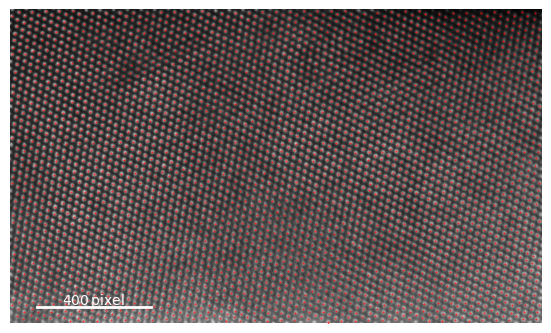

In [68]:
from vpcffit.vpcffit import create_vpcfs_images
cluster_blur_vpcf, origin = exp_vPCF[0]
cluster_exp_vpcf = exp_vPCF[1]
cluster_lattice = exp_vPCF[2]
cluster_lattice.plot(markersize = 0.4, title='', colorbar=None, axes_off = True)

In [69]:
#ERRASE
from vpcffit.vpcffit import create_vpcfs_images
cluster_lattice = sublattices
#cluster_lattice.plot(markersize = 0.4, title='', colorbar=None, axes_off = True)


In [70]:
from vpcffit.vpcffit import crop_at_position
imstack_single = []
coor_single = []
coordinates_around_point = []
window_size = 100
coord = np.round(cluster_lattice.atom_positions).astype(int)
for value in tqdm(coord):
    im = crop_at_position(image,window_size,window_size,value[0], value[1])
    # if im.shape == (window_size, window_size):
    imstack_single.append(im) 
    given_point = [value[0], value[1]]
    x_comp = (cluster_lattice.atom_positions[:,1] - given_point[1])
    y_comp = (cluster_lattice.atom_positions[:,0]  - given_point[0])
    distances = ((cluster_lattice.atom_positions[:,1] - given_point[1])**2 + (cluster_lattice.atom_positions[:,0]  - given_point[0])**2)**0.5
    indices = np.where(distances <= window_size)[0]
    coordinates_around_point.append(cluster_lattice.atom_positions[indices])
    coor_single.append(given_point)

  0%|          | 0/3462 [00:00<?, ?it/s]

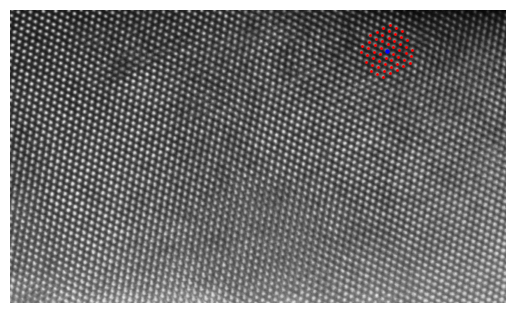

In [72]:
fig, ax = plt.subplots()
ind = np.random.randint(0, len(imstack_single))
points = np.array(coordinates_around_point[ind])
#ax.scatter(np.array(coor_single)[:,0],np.array(coor_single)[:,1], c='yellow',s=1)
ax.scatter(points[:,0],points[:,1], c='red',s=1)
ax.scatter(coor_single[ind][0],coor_single[ind][1], c='blue',s=5)
ax.imshow(-image, cmap='Grays')
plt.axis("off")
plt.show()

The process of generating vPCF and locating its peaks for each atomic position takes a long time, and hence, it is better to save the data while it is creating them. The data will be saved in frames each frame, each of them corresponds to a single atomic column position. In the next cell we create the functions to save and read the data in h5 files. 

In [73]:
import h5py
import numpy as np
import os

def init_vpcf_h5(filename, image_shape=(1000, 1000)):
    """
    Initialize an HDF5 file for storing vPCF data.
    Each frame stores:
      - atomic_position: (2,) coordinate
      - vpcf_origin: (2,) coordinate
      - vpcf_peaks: variable-length (N_peaks, 2)
      - vpcf_image: fixed (H, W)
    """
    with h5py.File(filename, 'w') as f:
        grp = f.create_group("experiments")
        vlen_float = h5py.vlen_dtype(np.float16)

        # Fixed-shape datasets
        grp.create_dataset(
            "atomic_positions", shape=(0, 2),
            maxshape=(None, 2), dtype=np.float16
        )
        grp.create_dataset(
            "vpcf_origin", shape=(0, 2),
            maxshape=(None, 2), dtype=np.float16
        )
        grp.create_dataset(
            "vpcf_images", shape=(0, *image_shape),
            maxshape=(None, *image_shape), dtype=np.float16
        )

        # Variable-length peaks (different number of peaks per frame)
        grp.create_dataset(
            "vpcf_peaks", shape=(0,), maxshape=(None,), dtype=vlen_float
        )
        grp.create_dataset(
            "peaks_shapes", shape=(0, 2), maxshape=(None, 2), dtype=np.int16
        )

def append_vpcf_frame(filename, atomic_position, vpcf_origin, vpcf_peaks, vpcf_image):
    """
    Append one vPCF frame (atomic_position, origin, peaks, image) to the HDF5 file.
    """
    with h5py.File(filename, 'a') as f:
        grp = f["experiments"]
        idx = len(grp["atomic_positions"])

        # Resize for the new frame
        grp["atomic_positions"].resize((idx + 1, 2))
        grp["vpcf_origin"].resize((idx + 1, 2))
        grp["vpcf_images"].resize((idx + 1, *grp["vpcf_images"].shape[1:]))
        grp["vpcf_peaks"].resize((idx + 1,))
        grp["peaks_shapes"].resize((idx + 1, 2))

        # Write data
        grp["atomic_positions"][idx] = np.array(atomic_position, dtype=np.float16)
        grp["vpcf_origin"][idx] = np.array(vpcf_origin, dtype=np.float16)
        grp["vpcf_images"][idx] = vpcf_image.astype(np.float16)
        grp["vpcf_peaks"][idx] = vpcf_peaks.flatten().astype(np.float16)
        grp["peaks_shapes"][idx] = np.array(vpcf_peaks.shape, dtype=np.int16)

def read_vpcf_frame(filename, frame_index):
    """
    Read one frame (atomic_position, origin, peaks, image) from the HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        grp = f["experiments"]

        atomic_position = grp["atomic_positions"][frame_index]
        vpcf_origin = grp["vpcf_origin"][frame_index]

        flat_peaks = grp["vpcf_peaks"][frame_index]
        peaks_shape = grp["peaks_shapes"][frame_index]
        vpcf_peaks = flat_peaks.reshape(peaks_shape)

        vpcf_image = grp["vpcf_images"][frame_index]

    return atomic_position, vpcf_origin, vpcf_peaks, vpcf_image


Now let's extract the vPCF at each atomic column position.

In [ ]:
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output
from vpcffit.vpcffit import extract_peak_coords
from tqdm.notebook import tqdm

plot = False
init_vpcf_h5(Path(img_path).stem+'_100pixels.h5', image_shape=(999, 999))

if plot:
    fig, ax = plt.subplots(figsize=(8, 8))

for i in tqdm(range(len(coordinates_around_point))):
    vpcf, orig = so.get_vpcf(
                  xlim = [-10, 10],
                  ylim = [-10, 10],
                  coords1 = coordinates_around_point [i]*pixel_size,
                  d = 0.02,
                  )
    blur_vpcf = gaussian_filter(vpcf.astype('float32'), sigma = 3)
    vpcf_peaks = extract_peak_coords(orig, blur_vpcf, method = 'gauss')
    append_vpcf_frame(Path(img_path).stem+'_100pixels.h5', np.array(coor_single[i]), orig, vpcf_peaks, blur_vpcf)
    
    #PLOTS AND UPDATE THE VPCFS AND THE PEAKS TO VERIFY PROPER FITTING
    if plot:
        ax.clear()
        ax.imshow(np.array(blur_vpcf), cmap='grey')
        ax.scatter(vpcf_peaks[:, 1]+orig[1], vpcf_peaks[:,0]+orig[1], c='r', alpha = 0.3, s=2, label='DataBase')
        clear_output(wait=True)
        display(fig)

    

  0%|          | 0/3462 [00:00<?, ?it/s]

In [25]:

##FUNCTION
def read_vpcf_frame(filename, frame_index):
    """
    Read one frame (atomic_position, origin, peaks, image) from the HDF5 file.
    """
    with h5py.File(filename, 'r') as f:
        grp = f["experiments"]

        atomic_position = grp["atomic_positions"][frame_index]
        vpcf_origin = grp["vpcf_origin"][frame_index]

        flat_peaks = grp["vpcf_peaks"][frame_index]
        peaks_shape = grp["peaks_shapes"][frame_index]
        vpcf_peaks = flat_peaks.reshape(peaks_shape)

        vpcf_image = grp["vpcf_images"][frame_index]

    return atomic_position, vpcf_origin, vpcf_peaks, vpcf_image

# ##Implementation
# atomic_positions2 = []
# vpcf_origin2 = []
# vpcf_peaks2 = []
# vpcf_image2 = []
# for i in tqdm(range(11505)):
#     atomic_position, vpcf_origin, vpcf_peaks, vpcf_image = read_vpcf_frame(Path(img_path).stem+'.h5', i)
#     atomic_positions2.append(atomic_position)
#     vpcf_origin2.append(vpcf_origin)
#     vpcf_peaks2.append(vpcf_peaks)
#     vpcf_image2.append(vpcf_image)

The next cell allows you to read a h5 file with the information of the atomic position, vPCF (including the origin) and the vPCF peaks, extracted in the previous cell. 

In [27]:
atomic_positions2 = []
vpcf_origin2 = []
vpcf_peaks2 = []
vpcf_image2 = []
for i in tqdm(range(13402)):
    atomic_position, vpcf_origin, vpcf_peaks, vpcf_image = read_vpcf_frame(Path(img_path).stem+'_100pixels.h5', i)
    atomic_positions2.append(atomic_position)
    vpcf_origin2.append(vpcf_origin)
    vpcf_peaks2.append(vpcf_peaks)
    vpcf_image2.append(vpcf_image)

  0%|          | 0/13402 [00:00<?, ?it/s]

Now we can plot one of the vPCF and the corresponding peaks

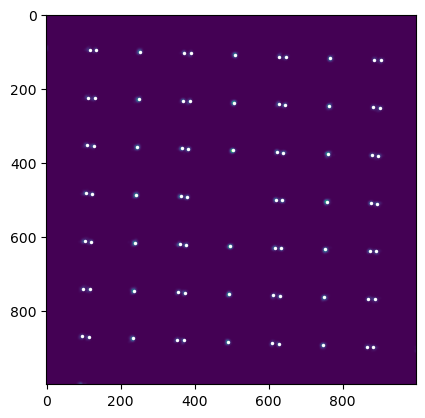

In [28]:
index = 10
plt.imshow(vpcf_image2[index])
plt.scatter(vpcf_peaks2[index][:, 1]+vpcf_origin2[index][1], vpcf_peaks2[index][:,0]+vpcf_origin2[index][1], c='white', alpha = 1, s=2, label='DataBase')


### Clustering the data to reduce dimensionality

The vPCFs calculated at each atomic column are clustered using a miniBatchKmeans algorithm to reduce the data dimensionality and run the vPCF match algorithm only on the clusters. This results in a much faster process that matches individual vPCF for each atomic column. 
This clustering algorithm requires defining the number of clusters in advance and thus, a large number of clusters would be recommended (e.g., 20), since the vPCF matching procedure can further reduce the number of regions. 

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,
    metric='cosine'
)
flat_vPCF = np.array(vpcf_image2).reshape([-1, 999*999])
labels = clusterer.fit_predict(flat_vPCF)

In [29]:
from sklearn.cluster import MiniBatchKMeans
batch_size = 512

mbk = MiniBatchKMeans(n_clusters=10, batch_size=batch_size, random_state=0)

for batch_start in range(0, len(vpcf_image2), batch_size):
    batch_end = min(batch_start + batch_size, len(vpcf_image2))
    X_batch = np.array(vpcf_image2[batch_start:batch_end]).reshape(batch_end-batch_start, -1)
    mbk.partial_fit(X_batch)

C:\Users\scaldero\anaconda3\envs\TEM_v2\lib\site-packages\sklearn\cluster\_kmeans.py:1955: UserWarning:

MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=2



In [30]:
all_labels = np.zeros(len(vpcf_image2), dtype=int)
for batch_start in range(0, len(vpcf_image2), batch_size):
    batch_end = min(batch_start + batch_size, len(vpcf_image2))
    X_batch = np.array([img.ravel() for img in vpcf_image2[batch_start:batch_end]])
    all_labels[batch_start:batch_end] = mbk.predict(X_batch)

In [31]:
centers_clusters = mbk.cluster_centers_.reshape(-1, 999, 999)

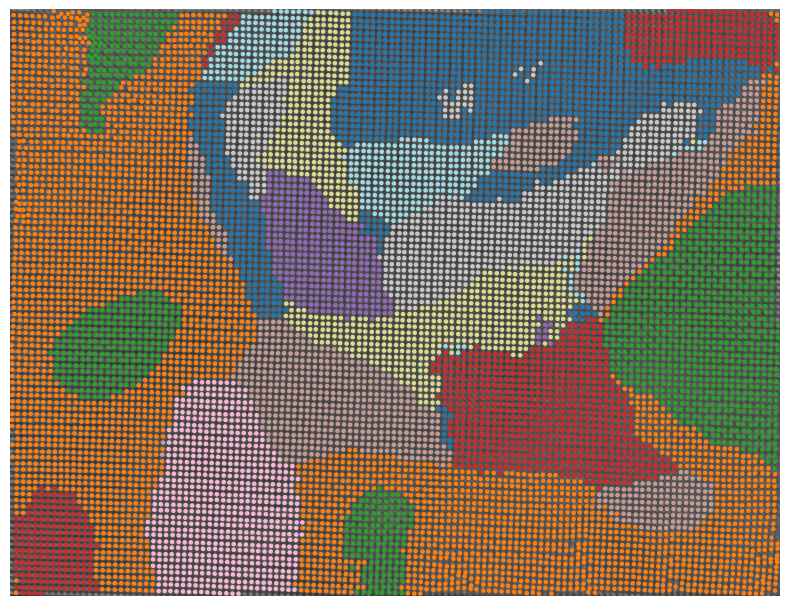

In [36]:
import numpy as np
import matplotlib as mpl

n_clusters = mbk.n_clusters
cmap = plt.get_cmap('tab20', n_clusters)  # discrete colormap with n_clusters
norm = mpl.colors.BoundaryNorm(np.arange(n_clusters+1)-0.5, n_clusters)

# Assign colors to each label
colors = [cmap(i) for i in all_labels]

fig, ax = plt.subplots(figsize=(8, 8))

# Plot the image
ax.imshow(image, cmap='gray', origin='lower')

# Overlay scatter
ax.scatter(
    np.array(atomic_positions2)[:, 0],
    np.array(atomic_positions2)[:, 1],
    c=colors,
    s=5
)
ax.axis("off")
plt.tight_layout()
plt.show()

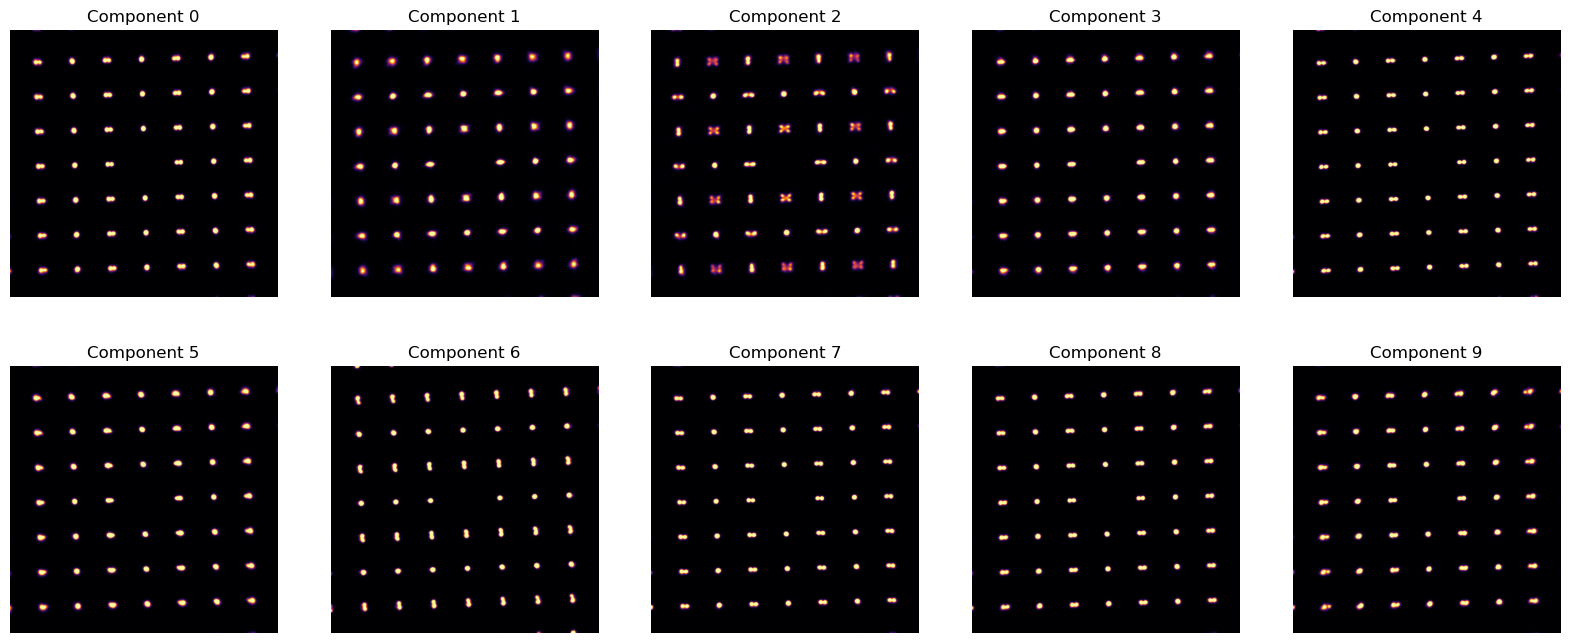

In [33]:
import matplotlib.gridspec as gridspec
rows, cols = 2, 5
gs2 = gridspec.GridSpec(rows, cols)

fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))

for i in range(mbk.n_clusters):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(centers_clusters[i,:], cmap = 'inferno', origin = 'lower', vmax = 20)
    ax2.set_title('Component ' + str(i))
    plt.tick_params(labelsize = 18)
    plt.axis('off')
plt.show()

In [34]:
from scipy.ndimage import gaussian_filter
vpcfs_clustered =  centers_clusters
vpcf_peaks_list_clusters = []
for vpcf in tqdm(vpcfs_clustered):
    orig = [np.array(vpcf).shape[0]/2,np.array(vpcf).shape[1]/2]
    blur_vpcf = gaussian_filter(vpcf, sigma = 1)
    vpcf_peaks = extract_peak_coords(orig,np.array(blur_vpcf), min_dist = 8)
    vpcf_peaks_list_clusters.append(vpcf_peaks)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.48s/it]
